# Acquiring and exploring our own EEG data using a Bitbrain 16-channel headset

**Authors**:

 - Javi Rameerez javi@rameerez.com | [@rameerez [tw]](http://twitter.com/rameerez)

---


_This code is Open Source, released under a GPL License._

We will be using a 16-ch, wet [Bitbrain](https://bitbrain.com) EEG headset like this one:

<img src="assets/bitbrain-eeg-headset.jpg" alt="Bitbrain's EEG headset" style="width: 1024px;"/>


## Electrode placement

<img src="assets/eeg-10-20-location.png" alt="International EEG 10-20 system" style="width: 300px;"/>

**TODO**: this explanation is incomplete! Detail the location of each electrode and correspondance with channels

Basically, we've used 8 electrodes in C1 through C4 and FC1 through FC4, the next 4 in the frontal cortex and the next 4 in TODO.

Reference is Cz and ground is A1.

## Methodology

### Sampling methodology & EEG data structure

Our headset makes about 256 measurements per second and per channel (we need to actually verify this with the manufacturer).

The stored EEG dataset looks like this:

| timestamp   | sequence | battery | flags | EEG-ch1         | EEG-ch2 | ... | EEG-ch16         |
|-------------|----------|---------|-------|-----------------|---------|-----|------------------|
| 11333317601 | 24377    | -2      | 0     | 14440.732098739 | ...     | ... | -1316.9463302375 |
| ...         | ...      | ...     | ...   | ...             | ...     | ... | ...              |
| 11333350144 | 24378    | -2      | 0     | ...             | ...     | ... | ...              |


The EEG data contains rows, each row corresponds to one measurement and is identified with a `timestamp`. The first 8 measurements share the same `timestamp`, the next 8 measurements share another (non consecutive) timestamp, and so on.

What a `timestamp` is remains unknown for the moment (it is not milliseconds nor seconds since Jan 1, 1970 -- it's not a UNIX timestamp as far as we know). But we know that approximately every second, the system stores 256 measurements (belonging to 32 different timestamps).

### Labelling tasks

We asked the subject to sit down and remain calm. Then, the labelling task starts. For 10 seconds, the subject needs to think about moving the left hand. Then, for another 10 seconds, the subject needs to thing about moving the right hand. Finally, for 10 seconds, the subject rests.

## Data exploration

In [8]:
import pandas as pd
%matplotlib inline

In [6]:
df = pd.read_csv("data/3-thinking-about-moving-hands-2-BBT-E16-AAA005-2019-11-08_18-45-48/EEG.csv")

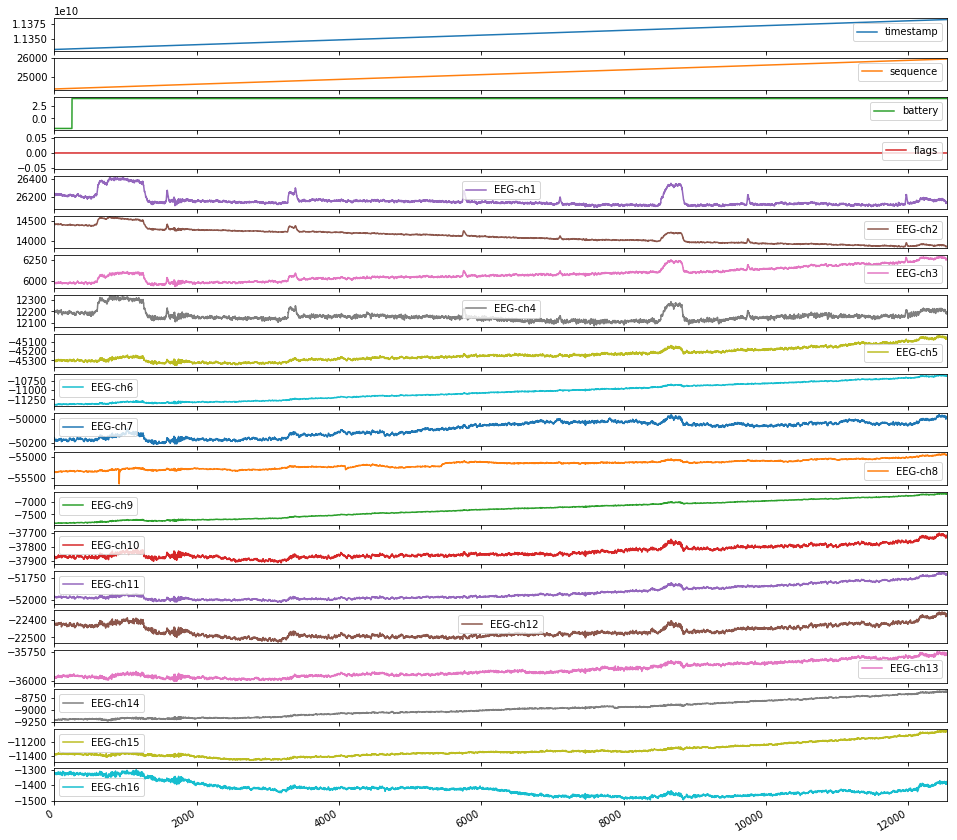

In [7]:
df.plot(subplots=True, figsize=(16, 16));

## Data labelling

For dataset #3, we know that we started the labelling task at `starting_seconds`.

Each second contains many `samples_per_second`.

The first measurement of the labelling task is then `starting_sample`.

Each labelling task lasts for `seconds_per_training_label`.

This way we can know the measurement corresponding to the start and end of every labelling task.

In [9]:
starting_seconds = 12.52
samples_per_second = 256

starting_sample = int(starting_seconds * samples_per_second)

seconds_per_training_label = 10
samples_per_training_label = seconds_per_training_label * samples_per_second

first_label_start = starting_sample
second_label_start = starting_sample + samples_per_training_label
third_label_start = second_label_start + samples_per_training_label
third_label_end = third_label_start + samples_per_training_label

In [10]:
for i, row in df.iterrows():
    if first_label_start <= i <= second_label_start:
        df.at[i, 'label'] = "left"
        df.at[i, 'label_code'] = 1
    elif second_label_start <= i <= third_label_start:
        df.at[i, 'label'] = "right"
        df.at[i, 'label_code'] = 2
    elif third_label_start <= i <= third_label_end:
        df.at[i, 'label'] = "rest"
        df.at[i, 'label_code'] = 0
    else:
        df.at[i, 'label'] = "none"
        df.at[i, 'label_code'] = -1

In [11]:
df["label_code"] = df["label_code"].astype(int)

In [12]:
df.to_pickle("data/3-thinking-about-moving-hands-2-BBT-E16-AAA005-2019-11-08_18-45-48/labelled-eeg.pkl")

## Exploring the EEG by label

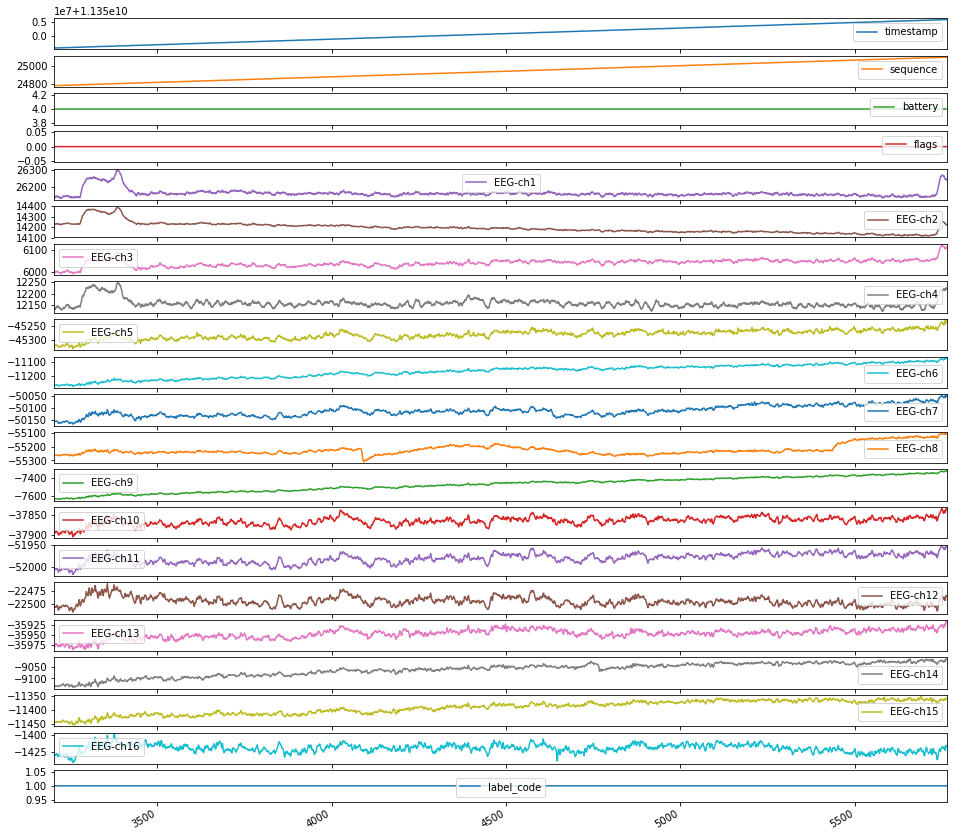

In [13]:
df.loc[df['label'] == "left"].plot(subplots=True, figsize=(16, 16));

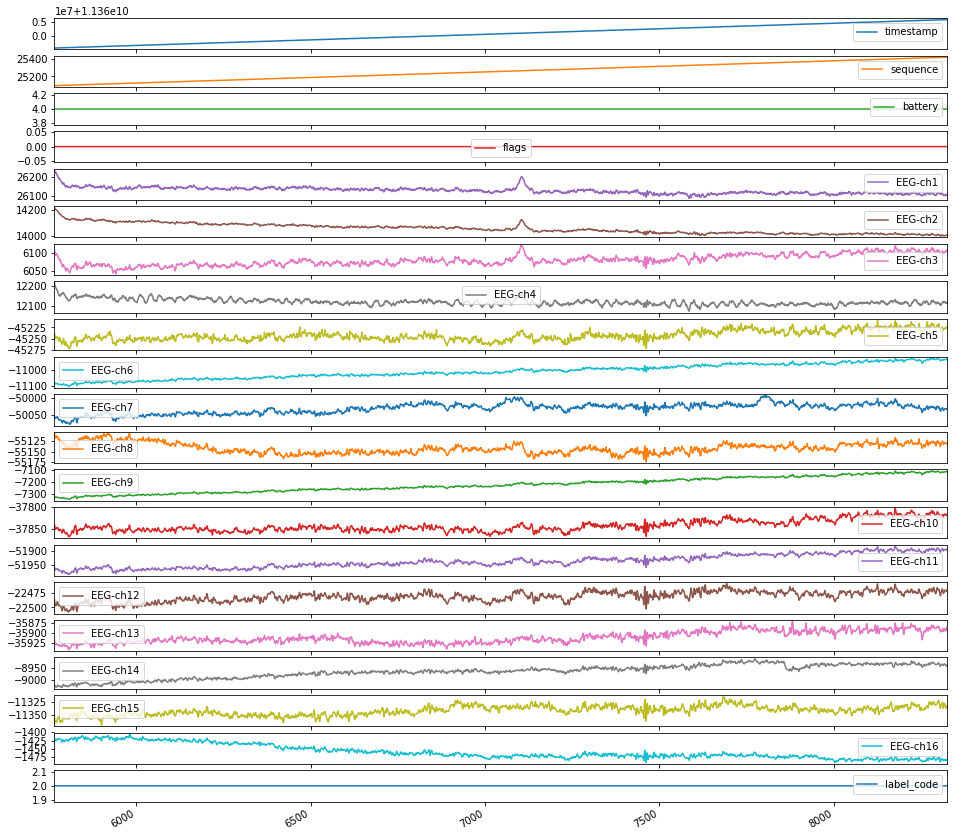

In [14]:
df.loc[df['label'] == "right"].plot(subplots=True, figsize=(16, 16));

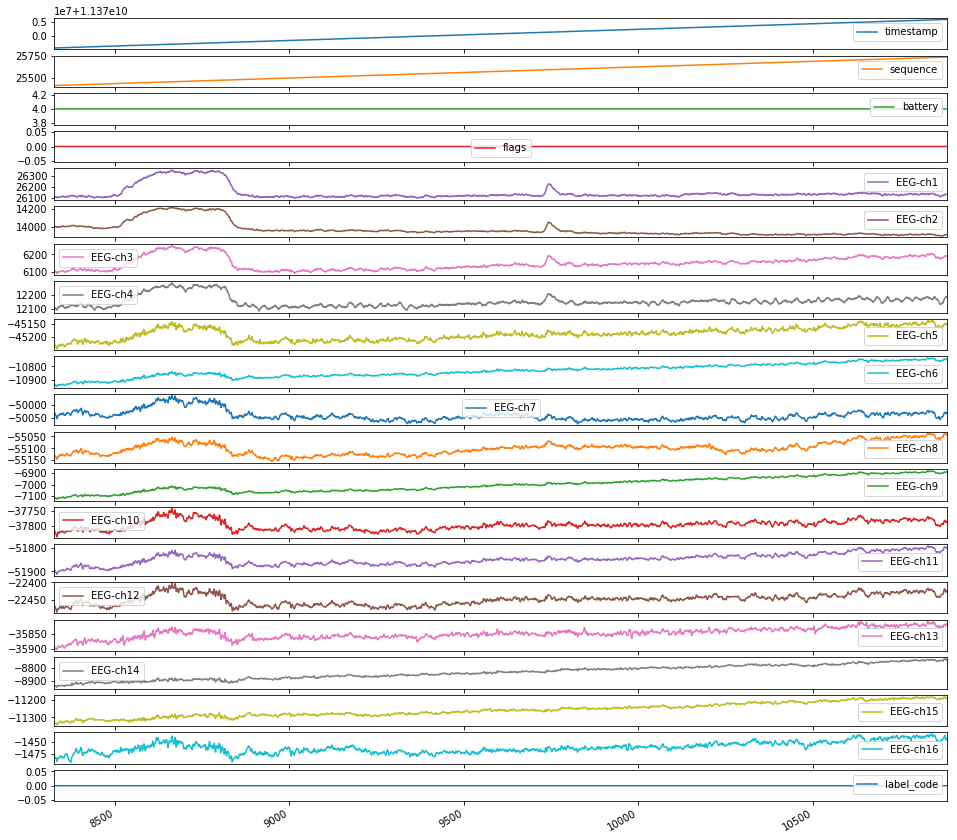

In [15]:
df.loc[df['label'] == "rest"].plot(subplots=True, figsize=(16, 16));